In [1]:
import sys
sys.path.append('..')

from tools.siren import *
from tools.table import *

from functools import partial

from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
table = Table('cprof_mu_train_10000ev.h5')

ene_bins = table.normalize(0, table.binning[0])
# cos_bins = table.normalize(1, np.linspace(min(table.binning[1]), max(table.binning[1]), 200))
# trk_bins = table.normalize(2, np.linspace(min(table.binning[2]), max(table.binning[2]), 200))

cos_bins = table.normalize(1, np.linspace(0.3, max(table.binning[1]), 50))
trk_bins = table.normalize(2, np.linspace(min(table.binning[2]), 400, 50))

cos_trk_mesh = np.array([[x,y] for x in cos_bins for y in trk_bins])
linear_interpolator = interpolate.interp1d(table.binning[0], ene_bins, kind='linear')
grid_shape = (table.binning[1].shape[0]*table.binning[2].shape[0],3)

siren_light_profile, siren_params = load_siren_jax('siren_cprof_mu.pkl')

### Let's look for the scale of 'random fluctuations'

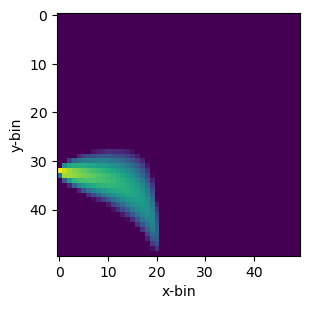

In [3]:
energy = 500 # MeV
evaluation_grid = jnp.array(np.array([[linear_interpolator(energy), x, y] for x in cos_bins for y in trk_bins]))
photon_weights, _ = siren_light_profile.apply(siren_params, evaluation_grid)

reco_value = np.array(photon_weights).reshape(len(cos_bins), len(trk_bins))
fig, axes = plt.subplots(1,1, figsize=(3,3))
fig.patch.set_facecolor('white')
im0 = axes.imshow(reco_value, norm=LogNorm(vmin=0.015))
#fig.colorbar(im0, ax=axes)
fig.tight_layout()
plt.gca().set_xlabel('x-bin')
plt.gca().set_ylabel('y-bin')
plt.show()

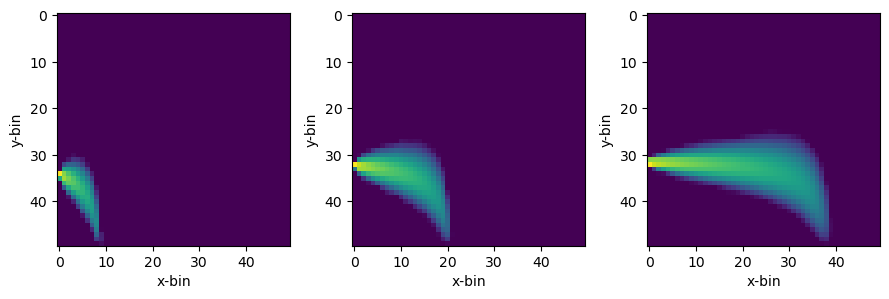

In [4]:
fig, axes = plt.subplots(1,3, figsize=(9,3))

energies = [300, 500, 800]

for i, energy in enumerate(energies):

    # since we are slicing SIREN from 3D to 2D but the slice change dynamically this needs to remain inide this function
    evaluation_grid = jnp.array(np.array([[linear_interpolator(energy), x, y] for x in cos_bins for y in trk_bins]))
    photon_weights, _ = siren_light_profile.apply(siren_params, evaluation_grid)
    reco_value = np.array(photon_weights).reshape(len(cos_bins), len(trk_bins))
    fig.patch.set_facecolor('white')
    im0 = axes[i].imshow(reco_value, norm=LogNorm(vmin=0.012))
    axes[i].set_xlabel('x-bin')
    axes[i].set_ylabel('y-bin')
    
#fig.colorbar(im0, ax=axes)
fig.tight_layout()
# plt.gca().set_xlabel('x-bin')
# plt.gca().set_ylabel('y-bin')
plt.show()

### Study relation of number of points above cut off and a Nphot for a given binning choice

In [5]:
def normalize(v, epsilon=1e-8):
    return v / (jnp.linalg.norm(v) + epsilon)

def generate_orthonormal_basis(v):
    v = normalize(v)
    not_v = jnp.array([1.0, 0.0, 0.0])
    cond = jnp.abs(jnp.dot(v, not_v)) > 0.9
    not_v = jnp.where(cond, jnp.array([0.0, 1.0, 0.0]), not_v)
    u = normalize(jnp.cross(v, not_v))
    w = jnp.cross(v, u)
    return jnp.stack([u, w, v], axis=-1)

@partial(jax.jit, static_argnums=(3,))
def generate_random_cone_vectors(R, theta, key, num_vectors):
    R = normalize(R)
    theta = jnp.clip(theta, 1e-6, jnp.pi - 1e-6)

    key1, key2 = random.split(key)
    phi = random.uniform(key1, (num_vectors,), minval=0, maxval=2 * jnp.pi)

    sin_theta = jnp.sin(theta)
    cos_theta = jnp.cos(theta)
    x = jnp.cos(phi) * sin_theta
    y = jnp.sin(phi) * sin_theta
    z = cos_theta * jnp.ones_like(x)

    basis = generate_orthonormal_basis(R)
    vectors = jnp.column_stack((x, y, z))
    rotated_vectors = jnp.einsum('ij,kj->ki', basis, vectors)

    return rotated_vectors

# def setup_interpolation(table):
#     ene_bins = table.normalize(0, table.binning[0])
#     cos_bins = table.normalize(1, np.linspace(0.3, max(table.binning[1]), 200))
#     trk_bins = table.normalize(2, np.linspace(min(table.binning[2]), 400, 200))
#     cos_trk_mesh = np.array([[x,y] for x in cos_bins for y in trk_bins])
#     x_data = table.binning[0]
#     y_data = ene_bins
#     grid_shape = (np.shape(cos_bins)[0]*np.shape(trk_bins)[0],3)
#     return cos_bins, trk_bins, cos_trk_mesh, (x_data, y_data), grid_shape

@jax.jit
def jax_linear_interp(x_data, y_data, x):
    """
    Simple linear interpolation implementation using JAX
    """
    # Find the index of the closest point below x for each point
    idx = jnp.searchsorted(x_data, x, side='right') - 1
    # Clip index to valid range
    idx = jnp.clip(idx, 0, len(x_data)-2)
    
    # Get x and y values for interpolation
    x0 = x_data[idx]
    x1 = x_data[idx + 1]
    y0 = y_data[idx]
    y1 = y_data[idx + 1]
    
    # Linear interpolation
    slope = (y1 - y0) / (x1 - x0)
    return y0 + slope * (x - x0)

@partial(jax.jit, static_argnums=(3))
def new_differentiable_get_rays(track_origin, track_direction, energy, Nphot, table_data, model_params, key):
    key, subkey = random.split(key)
    cos_bins, trk_bins, cos_trk_mesh, (x_data, y_data), grid_shape = table_data
    
    # Create the evaluation grid using JAX operations - using efficient meshgrid
    energy_interp = jax_linear_interp(x_data, y_data, energy)
    cos_mesh, trk_mesh = jnp.meshgrid(cos_bins, trk_bins, indexing='ij')  # Note the indexing='ij'
    evaluation_grid = jnp.stack([
        jnp.full_like(cos_mesh, energy_interp).ravel(),
        cos_mesh.ravel(),  # Maintain correct order: cos first
        trk_mesh.ravel(),  # trk second
    ], axis=1)
    
    # Initialize SIREN model
    model = SIREN(
        hidden_features=256,
        hidden_layers=3,
        out_features=1,
        outermost_linear=True
    )
    
    # Apply SIREN model
    photon_weights, _ = model.apply(model_params, evaluation_grid)
    # Get indices of top Nphot weights (using JAX operations)
    top_indices = jnp.argsort(-photon_weights.squeeze())[:Nphot]
    
    # Get the cos and trk values for these indices
    cos_trk_mesh = jnp.array(cos_trk_mesh)  # Ensure it's a JAX array
    selected_cos_trk = cos_trk_mesh[top_indices]
    
    # Split into separate cos and trk arrays
    selected_cos = selected_cos_trk[:, 0]
    selected_trk = selected_cos_trk[:, 1]
    photon_thetas = jnp.arccos(selected_cos)
    
    # Generate ray vectors and origins
    subkey, subkey2 = random.split(subkey)
    ray_vectors = generate_random_cone_vectors(track_direction, photon_thetas, subkey, Nphot)
    
    # Convert ranges to meters and compute ray origins
    ranges = (selected_trk * 300 + 300) / 100
    ray_origins = jnp.ones((Nphot, 3)) * track_origin[None, :] + ranges[:, None] * track_direction[None, :]
    
    return ray_vectors, ray_origins, ranges, photon_weights[top_indices], photon_thetas

In [9]:
#key = random.PRNGKey(1)
from tools.simulation import create_siren_grid

table_data = create_siren_grid(table)
siren_model, model_params = load_siren_jax('siren_cprof_mu.pkl')
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])

valid_N = []
energies = [300,400,500,600,700,800,900]
for energy in energies:
    Nphot = 100000
    key = random.PRNGKey(1)
    ray_vectors, ray_origins, ranges, photon_weights, photon_thetas = new_differentiable_get_rays(origin, direction, energy, Nphot, table_data, model_params, key)
    valid_N.append(np.sum(photon_weights>0.008))

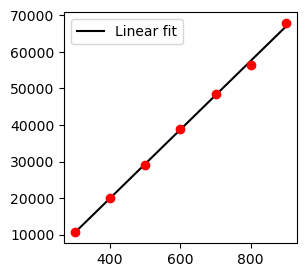

In [10]:
import numpy as np

# Create the linear fit
fig, axes = plt.subplots(1,1, figsize=(3,3))
coefficients = np.polyfit(energies, valid_N, 1)  # 1 indicates linear fit
fit_line = np.poly1d(coefficients)

plt.plot(energies, fit_line(energies), '-k', label=f'Linear fit')
plt.scatter(energies, valid_N, color='r', zorder=10)
plt.legend()

In [11]:
coefficients

array([    94.14714286, -17750.        ])